Подключаем необходимые библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from datetime import datetime, timedelta
import numpy as np

Читаем датасет

In [ ]:
df = pd.read_csv("/content/forms.csv", sep = ";")

# **Необходимые функции**

**Функция, для построения графика распределения уникальных пользователей по часам и по дням**

In [ ]:
def distribution_of_unique_users_by_hour(df):
  df['hour'] = df['t'].apply(lambda x: x[:13])

  unique_users_per_hour = df.groupby('hour')['visitor_id'].nunique().reset_index()

  sns.set(rc={'figure.figsize':(12, 8)})

  g = sns.lineplot(data=unique_users_per_hour, x='hour', y='visitor_id', marker = 'o', linestyle = '-')

  plt.title('Распределение уникальных пользователей по часам', size=15)
  g.set(xlabel=None)
  g.set(ylabel=None)
  plt.xticks(rotation=90)

  plt.show()

**Функция, для построения графика распределения уникальных пользователей по минутам в выбранный интервал**

In [ ]:
def distribution_of_unique_users_by_minute(df, t_start, t_end):
    df['t'] = pd.to_datetime(df['t'])
    filtered_data = df[(df['t'] >= t_start) & (df['t'] <= t_end)]

    unique_users_per_minute = filtered_data.groupby([filtered_data['t'].dt.date, filtered_data['t'].dt.hour, filtered_data['t'].dt.minute])['visitor_id'].nunique()

    index = pd.to_datetime([f"{date} {hour}:{minute}:00" for date, hour, minute in unique_users_per_minute.index])
    unique_users_per_minute.index = index

    plt.figure(figsize=(12, 6))

    unique_users_per_minute.plot(marker='o', linestyle='-')

    plt.title('Количество уникальных пользователей по минутам в часы')
    plt.xlabel('Время')
    plt.ylabel('Количество уникальных пользователей')
    plt.xticks(rotation=45)

    x_ticks = sorted(unique_users_per_minute.index.unique())
    plt.xticks(x_ticks, rotation=45)

    plt.grid(True)
    plt.tight_layout()

    plt.show()


**Функция для построения графика распределения выбранного события по часам и дням**

In [ ]:
def the_schedule_of_events_by_hour(df, event_name):
  df['hour'] = df['t'].apply(lambda x: x[:13])

  events = df[df['event_name'] == event_name]
  events_per_day_per_hour = events.groupby('hour').agg({
      'event_name' : 'size'
  }).reset_index()

  sns.set(rc={'figure.figsize':(12, 8)})
  g = sns.lineplot(data=events_per_day_per_hour, x='hour', y='event_name', marker = 'o', linestyle = '-')
  plt.title(f'Распределение заполненных полных форм по часам', size=15)
  g.set(xlabel=None)
  g.set(ylabel=None)
  plt.xticks(rotation=90)

  plt.show()

**Вывод таблицы выбросов по выбранному событию с указанием дат**

In [ ]:
def the_emission_table_for_the_event(df, event_name):
  df['t'] = pd.to_datetime(df['t'])
  events = df[df['event_name'] == event_name]
  events_per_hour_per_day = events.groupby([df['t'].dt.date, df['t'].dt.hour]).agg({
      'event_name' : 'size'
  })
  z_scores = zscore(events_per_hour_per_day['event_name'])
  outliers = events_per_hour_per_day[z_scores > 1]
  outliers = outliers.rename(columns = {'event_name' : event_name+'s'})
  print(outliers)

**Функция, выводящая информацию о трёх самых популярных комбинаций устройства, браузера, версий для выбранного временнного интервала**

In [ ]:
def summary_of_devices_during_the_period(df,t_start,t_end):

  filtered_data = df[(df['t'] >= t_start) & (df['t'] <= t_end)]

  popular_devices = filtered_data.groupby('os').size().nlargest(3)

  for device in popular_devices.index:
      device_data = filtered_data[filtered_data['os'] == device]
      if not device_data.empty:

          mode_os_version = device_data['os_version'].mode().iloc[0] if 'os_version' in device_data else None
          mode_browser = device_data['browser'].mode().iloc[0] if 'browser' in device_data else None
          mode_browser_version = device_data['browser_version'].mode().iloc[0] if 'browser_version' in device_data else None
          mode_adblock_flg = device_data['adblock_flg'].mode().iloc[0] if 'adblock_flg' in device_data else None


          print(f"Устройство: {device}")
          print(f"Версия ОС: {mode_os_version}")
          print(f"Браузер: {mode_browser}")
          print(f"Версия браузера: {mode_browser_version}")
          print(f"Блокировщик рекламы: {mode_adblock_flg}")
          print()
      else:
          print(f"Для устройства {device} нет данных")


**Функция, для вычисления id пользователей, что могут быть потенциальными ботами**

In [ ]:
def amount_events_per_user(df, event_name):
  amount_events_per_user = df[df['event_name'] == event_name].groupby('visitor_id').agg({'event_name' : 'size'}).rename(columns = {'event_name' : 'count'})
  z_scores = zscore(amount_events_per_user['count'])
  outliers = amount_events_per_user[z_scores > 2]
  print(outliers)

**Функция для определения списка ботов по подозрительной активности по конкретному событию**

In [ ]:
def suspicious_events_activity(df, event_name):
    amount_events_per_user = df[df['event_name'] == event_name].groupby('visitor_id').size().reset_index(name='count')
    z_scores = zscore(amount_events_per_user['count'])
    outliers = amount_events_per_user[z_scores > 1]
    return set(outliers['visitor_id'])

**Функция, что удаляет ботов по сформированным спискам **

In [ ]:
def removing_bots(df):
  intersection = []
  events = list(df['event_name'].unique())
  bots = suspicious_events_activity(df,events[0])
  for i in range(1,len(events)):
    bots = bots & suspicious_events_activity(df,events[i])
    intersection.append(len(bots)/len(suspicious_events_activity(df,events[i])))
  bots = list(bots)
  print(f'Процент пересечения подозрительных пользователей по всем событиям: {round(sum(intersection)/len(intersection),2)*100}%')
  return df[~df['visitor_id'].isin(bots)]

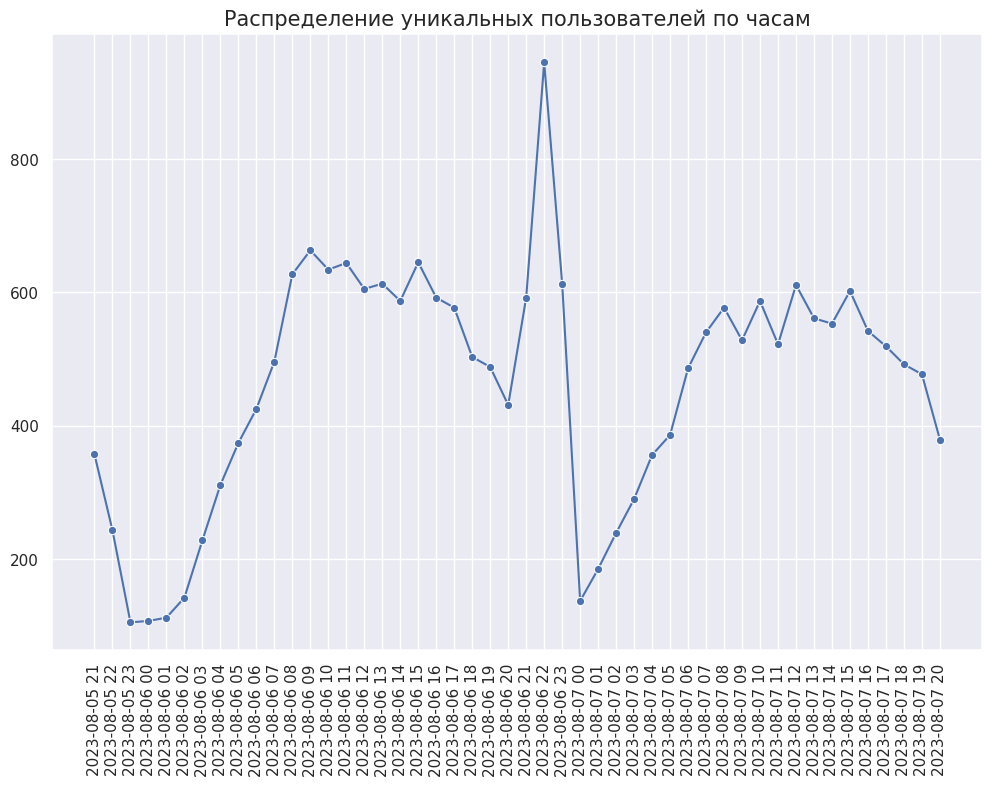

In [ ]:
distribution_of_unique_users_by_hour(df)

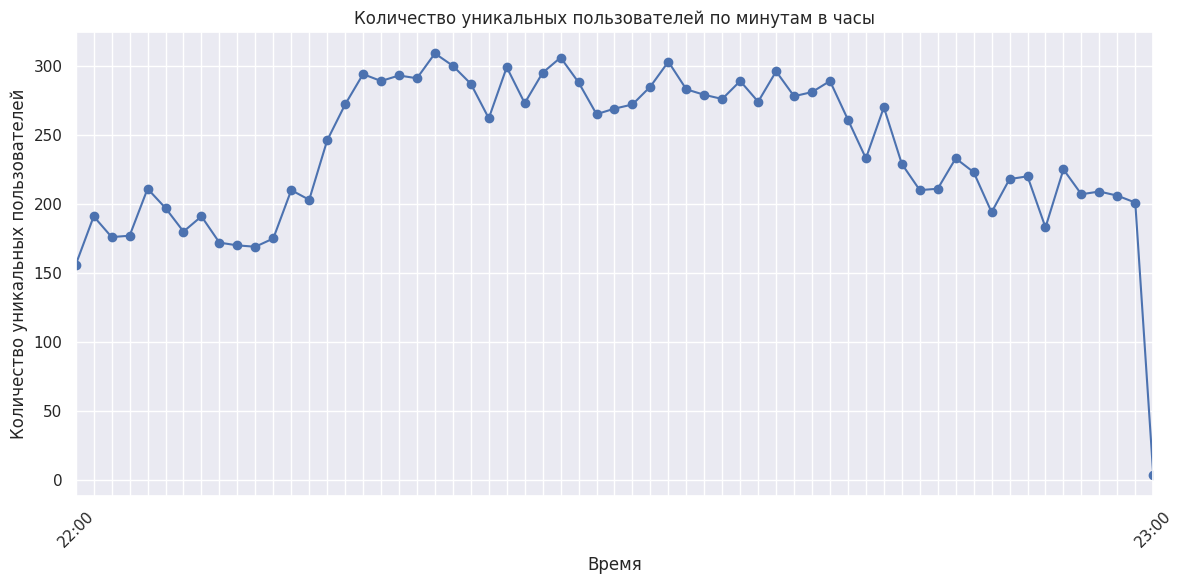

In [ ]:
distribution_of_unique_users_by_minute(df,'2023-08-06 22:00:00','2023-08-06 23:00:00')

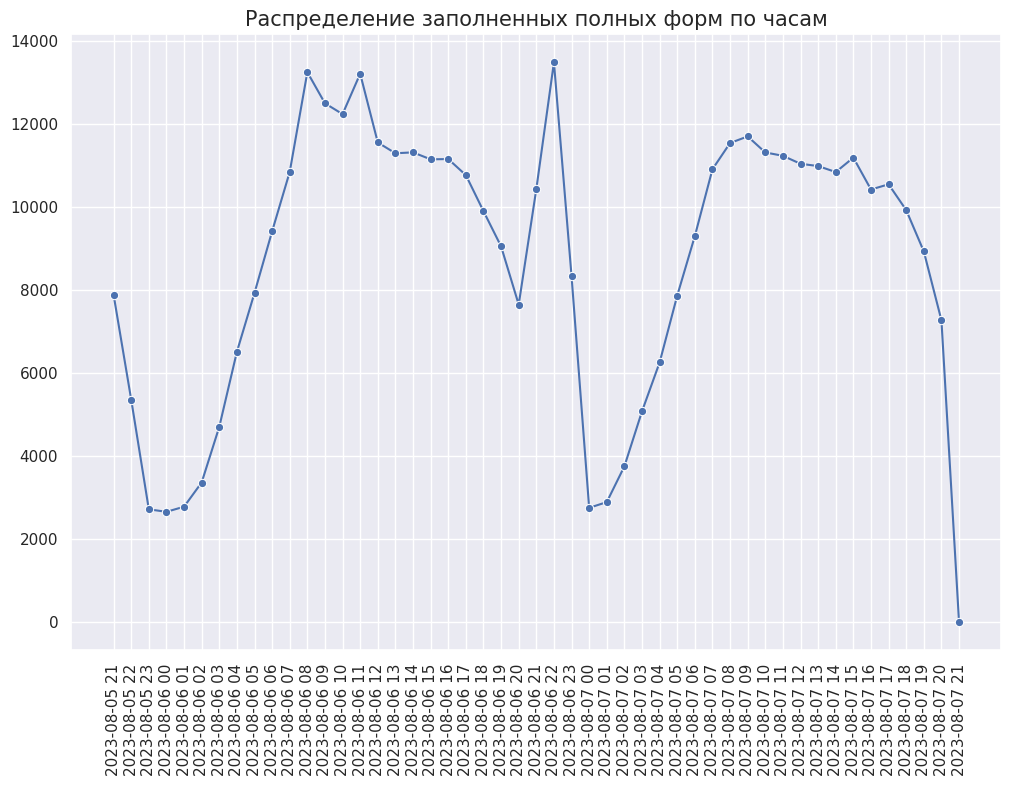

In [ ]:
the_schedule_of_events_by_hour(df,'page_view')

In [ ]:
the_emission_table_for_the_event(df,'page_view')

               page_views
t          t             
2023-08-06 8        13251
           9        12500
           10       12240
           11       13213
           22       13488


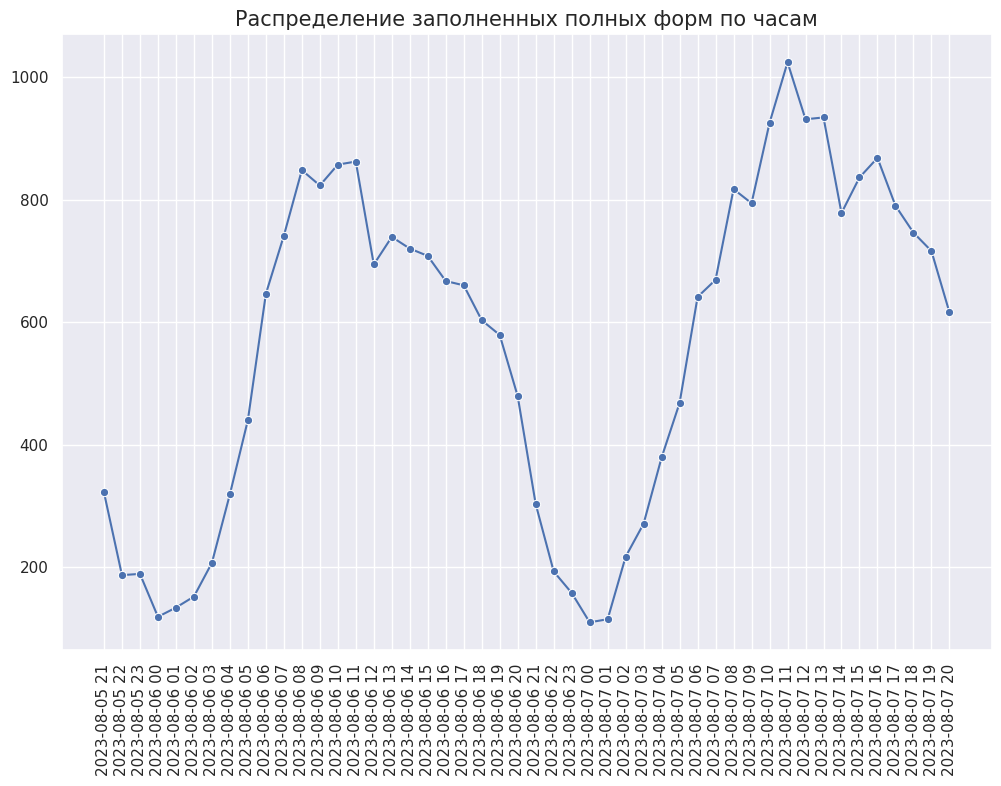

In [ ]:
the_schedule_of_events_by_hour(df,'autofill')

In [ ]:
the_emission_table_for_the_event(df,'autofill')

               autofills
t          t            
2023-08-06 8         848
           10        857
           11        862
2023-08-07 10        925
           11       1024
           12        931
           13        934
           16        868


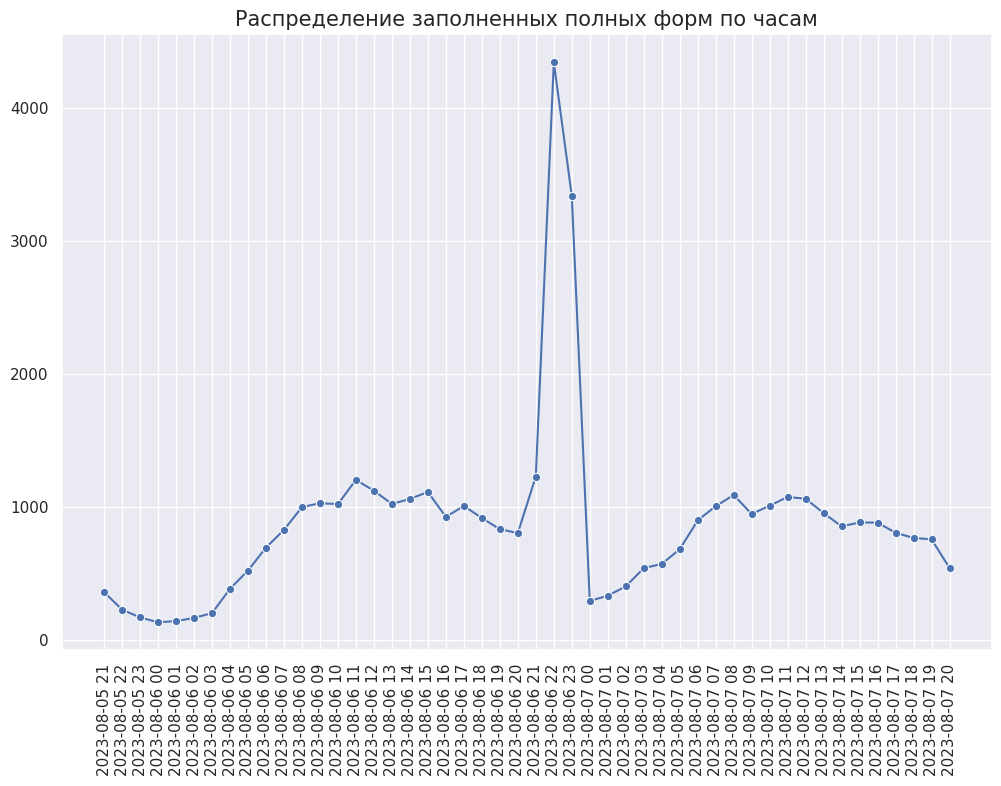

In [ ]:
the_schedule_of_events_by_hour(df,'short_application')

In [ ]:
the_emission_table_for_the_event(df,'short_application')

               short_applications
t          t                     
2023-08-06 22                4341
           23                3337


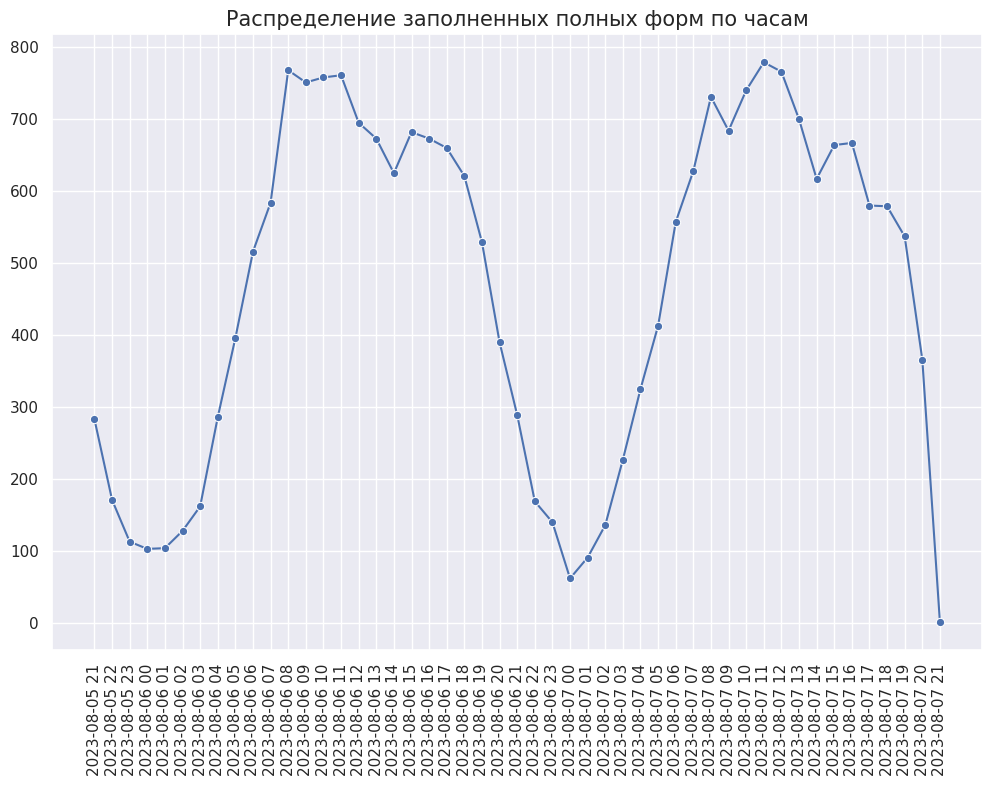

In [ ]:
the_schedule_of_events_by_hour(df,'full_application')

In [ ]:
the_emission_table_for_the_event(df,'full_application')

               full_applications
t          t                    
2023-08-06 8                 768
           9                 751
           10                758
           11                761
2023-08-07 8                 731
           10                740
           11                779
           12                766


In [ ]:
summary_of_devices_during_the_period(df,'2023-08-06 08:00:00','2023-08-06 11:00:00')

Устройство: Android
Версия ОС: 10.0
Браузер: Chrome Mobile
Версия браузера: 86
Блокировщик рекламы: 0

Устройство: iOS
Версия ОС: 13.3.1
Браузер: Mobile Safari
Версия браузера: 13.0
Блокировщик рекламы: 0

Устройство: Windows
Версия ОС: 10.0
Браузер: Chrome
Версия браузера: 105
Блокировщик рекламы: 0



In [ ]:
summary_of_devices_during_the_period(df,'2023-08-06 22:00:00','2023-08-06 23:00:00')

Устройство: Windows
Версия ОС: 10.0
Браузер: Chrome
Версия браузера: 105
Блокировщик рекламы: 0

Устройство: Android
Версия ОС: 10.0
Браузер: Chrome Mobile
Версия браузера: 86
Блокировщик рекламы: 0

Устройство: macOS
Версия ОС: 12.6
Браузер: Chrome
Версия браузера: 105
Блокировщик рекламы: 0



In [ ]:
summary_of_devices_during_the_period(df,'2023-08-07 08:00:00','2023-08-07 12:00:00')

Устройство: Android
Версия ОС: 10.0
Браузер: Chrome Mobile
Версия браузера: 86
Блокировщик рекламы: 0

Устройство: iOS
Версия ОС: 16.5.1
Браузер: Mobile Safari
Версия браузера: 13.0
Блокировщик рекламы: 0

Устройство: Windows
Версия ОС: 10.0
Браузер: Chrome
Версия браузера: 105
Блокировщик рекламы: 0



**Удалим ботов на основе их высокой активности**

In [ ]:
df.shape

(519293, 10)

In [ ]:
df = removing_bots(df)
print(df.shape)

Процент пересечения подозрительных пользователей по всем событиям: 48.0%
(513373, 10)


Распределение действий по ботам

In [ ]:
amount_events_per_user(df,'full_application')

                                                    count
visitor_id                                               
00D27010DCABA3074F61BE9EEB31E181A271B49C129A334...      3
02B39D196822A356FED45902F4410859B3A07C490C13ADA...      3
02ED4F0C3FA7B52E9AA23C5E22386C56AD420B071FA13B8...      3
0332BB6DBDE48B40C1B31F89359D19BB655E6736B61D39F...      3
04B4A34C7800806C950633DE16A25D8885D07CF90E480EE...      4
...                                                   ...
FBA8CF8DACF8134DFE08E22FAA39B4F10D08D8E5A2BB3CB...      4
FDF1222812CD33F686F25F87363EB749FAAB8551169340C...      4
FE590642027B4B3A03728FDC8A90A2E641788CF30F88DAF...      3
FEF47EBA5C2BAA74ED9204631D30BE4AB669FE76832C3F5...      3
FF68EBA758665B62C573FB7EE0813FA3714F9336C014D76...      3

[350 rows x 1 columns]


# **Проверка гипотезы старых версий устройств и браузеров**

In [ ]:
df['date_hour'] = df['t'].apply(lambda x: x[:13])
df_gr_hour = df.groupby('date_hour', as_index=False).agg({'visitor_id': 'count'}) \
            .rename(columns={'visitor_id': 'count'})


df_gr_hour_event_name = df.groupby(['date_hour', 'event_name'], as_index=False).agg({'visitor_id': 'count'}) \
            .rename(columns={'visitor_id': 'count'})

**Операционные системы и версии**

In [ ]:
df.groupby('os', as_index=False).agg({'visitor_id': 'count'}).rename(columns={'visitor_id': 'count'}) \
            .sort_values('count', ascending=False)

,os,count
0,Android,252865
13,iOS,130803
11,Windows,112446
15,macOS,11780
4,Linux,6795
1,ChromeOS,3244
14,iPadOS,654
5,Mac OS X,116
10,Ubuntu,107
9,Tizen,56


In [ ]:
df[df['os'] == 'Android'].groupby('os_version', as_index=False).agg({'visitor_id': 'count'}).rename(columns={'visitor_id': 'count'}) \
            .sort_values('count', ascending=False).head(15)

,os_version,count
0,10.0,123215
1,11.0,42085
2,12.0,34566
4,13.0,29439
27,9.0,11176
26,8.1,4198
25,8.0,2650
21,7.0,1550
24,7.1.2,786
20,6.0.1,757


In [ ]:
df[df['os'] == 'iOS'].groupby('os_version', as_index=False).agg({'visitor_id': 'count'}).rename(columns={'visitor_id': 'count'}) \
            .sort_values('count', ascending=False).head(15)

,os_version,count
108,16.5.1,38495
46,13.3.1,10362
107,16.5,7429
104,16.3.1,7192
102,16.2,6459
100,16.1.1,4758
95,16.0,4643
109,16.6,4112
93,15.7.7,3127
99,16.1,2801


In [ ]:
df[df['os'] == 'Windows'].groupby('os_version', as_index=False).agg({'visitor_id': 'count'}).rename(columns={'visitor_id': 'count'}) \
            .sort_values('count', ascending=False).head(15)

,os_version,count
0,10.0,106450
2,7,4778
4,8.1,914
3,8,177
6,XP,53
5,Vista,9
1,2000,1


В операционных сисстемах нет ничего подозрительного.

**Версии браузеров**

Информация об актуальных версиях браузеров [отсюда](https://www.w3schools.com/browsers/browsers_chrome.asp). Были взяты только хром, опера, фирефокс, и сафари.

In [ ]:
df.groupby('browser', as_index=False).agg({'visitor_id': 'count'}).rename(columns={'visitor_id': 'count'}) \
            .sort_values('count', ascending=False).head(15)

,browser,count
13,Chrome Mobile,141835
11,Chrome,108829
54,Mobile Safari,87772
107,Yandex App,15930
47,MIUI Browser,14253
80,Samsung Browser,13716
110,Yandex.Browser for Android,12791
114,Yandex.Browser for iOS,7495
33,Firefox for iOS,6750
61,Opera Desktop,4617


In [ ]:
browsers_actual = df[(df['browser'] == 'Chrome') & (df['browser_version'] >= '108') |
                     (df['browser'] == 'Chrome Mobile') & (df['browser_version'] >= '108') |
                     (df['browser'] == 'Chrome for iOS') & (df['browser_version'] >= '108') |
                     (df['browser'] == 'Opera Desktop') & (df['browser_version'] >= '94') |
                     (df['browser'] == 'Opera Mobile') & (df['browser_version'] >= '94') |
                     (df['browser'] == 'Firefox') & (df['browser_version'] >= '109') |
                     (df['browser'] == 'Firefox for Mobile') & (df['browser_version'] >= '109') |
                     (df['browser'] == 'Firefox for iOS') & (df['browser_version'] >= '109') |
                     (df['browser'] == 'Safari') & (df['browser_version'] >= '15') |
                     (df['browser'] == 'Mobile Safari') & (df['browser_version'] >= '15') |
                     (df['browser'] == 'Edge') & (df['browser_version'] >= '109') |
                     (df['browser'] == 'Edge for Android') & (df['browser_version'] >= '109') |
                     (df['browser'] == 'Yandex App') & (df['browser_version'] >= '21') |
                     (df['browser'] == 'Yandex.Browser for Android') & (df['browser_version'] >= '21') |
                     (df['browser'] == 'Yandex.Browser for iOS') & (df['browser_version'] >= '21') |
                     (df['browser'] == 'MIUI Browser') & (df['browser_version'] >= '15') |
                     (df['browser'] == 'Samsung Browser') & (df['browser_version'] >= '15')]

browsers = ['Chrome', 'Opera Desktop', 'Firefox', 'Safari', 'Chrome Mobile', 'Chrome for iOS',
           'Opera Mobile', 'Firefox for Mobile', 'Firefox for iOS', 'Mobile Safari', 'Edge',
           'Edge for Android', 'Yandex App', 'Yandex.Browser for Android', 'Yandex.Browser for iOS',
           'MIUI Browser', 'Samsung Browser']
browsers_all = df[df['browser'].isin(browsers)]

In [ ]:
browsers_actual.shape

(256075, 11)

In [ ]:
browsers_all.shape

(492571, 11)

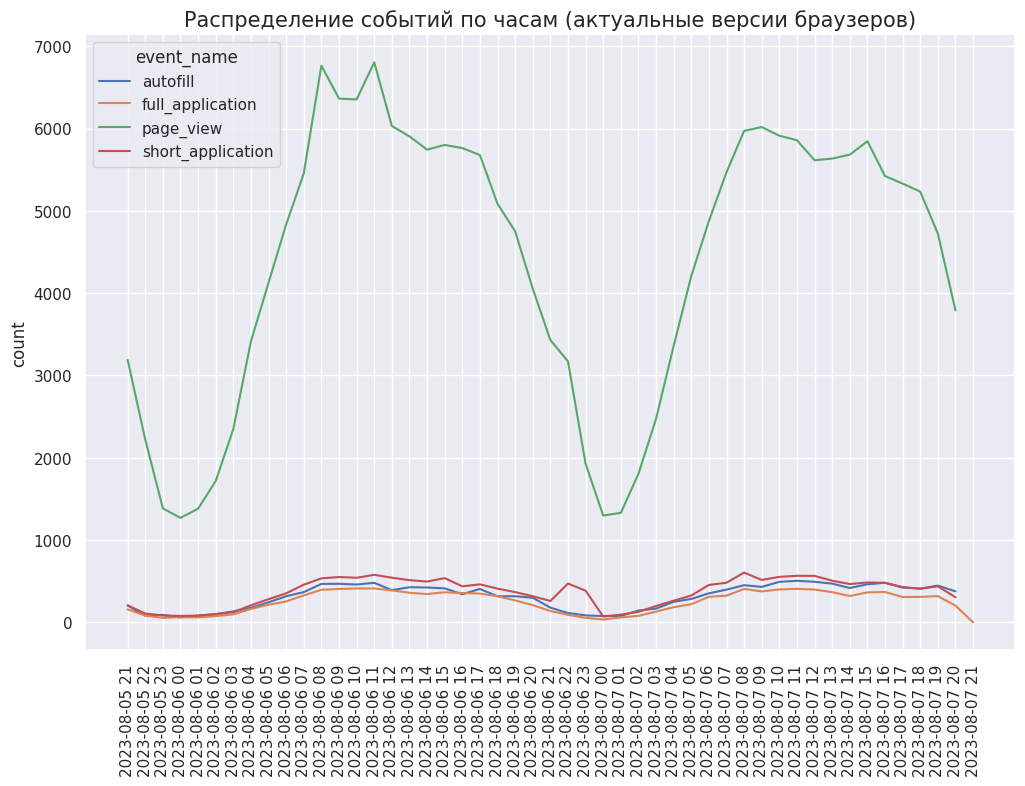

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})
br_act_gr_hour_event_name = browsers_actual.groupby(['date_hour', 'event_name'], as_index=False).agg({'visitor_id': 'count'}) \
            .rename(columns={'visitor_id': 'count'})

g = sns.lineplot(data=br_act_gr_hour_event_name, x='date_hour',
                 y='count', hue='event_name')
plt.title('Распределение событий по часам (актуальные версии браузеров)', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

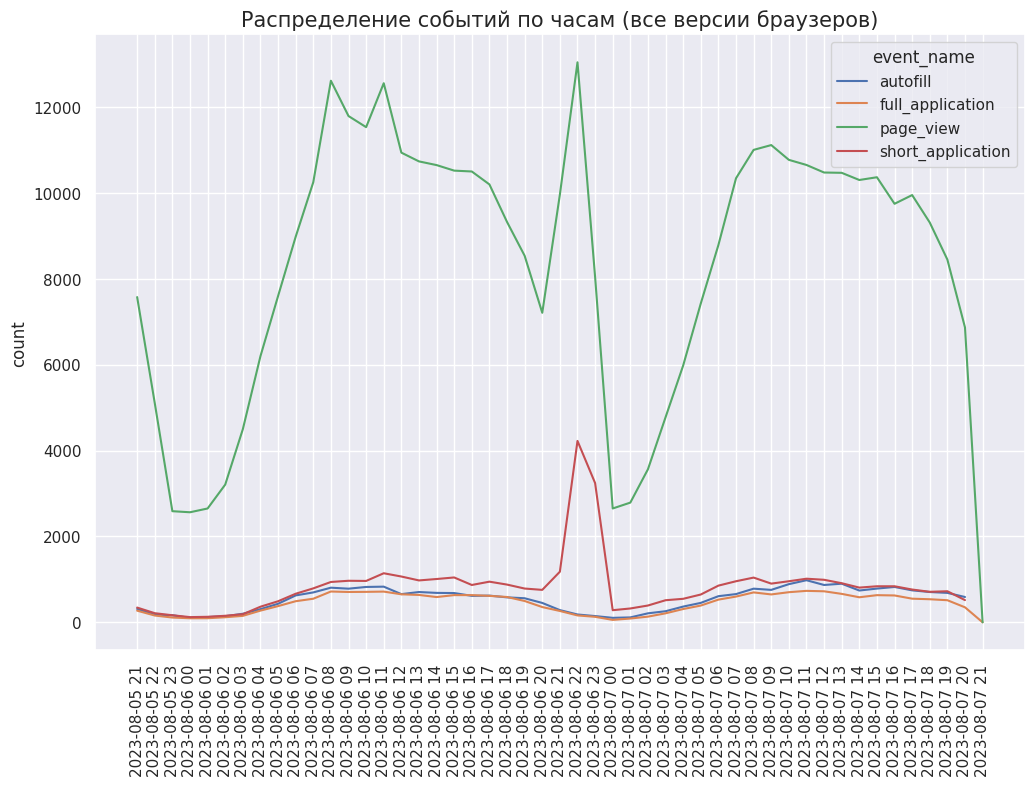

In [ ]:
br_all_gr_hour_event_name = browsers_all.groupby(['date_hour', 'event_name'], as_index=False).agg({'visitor_id': 'count'}) \
            .rename(columns={'visitor_id': 'count'})

g = sns.lineplot(data=br_all_gr_hour_event_name, x='date_hour',
                 y='count', hue='event_name')
plt.title('Распределение событий по часам (все версии браузеров)', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

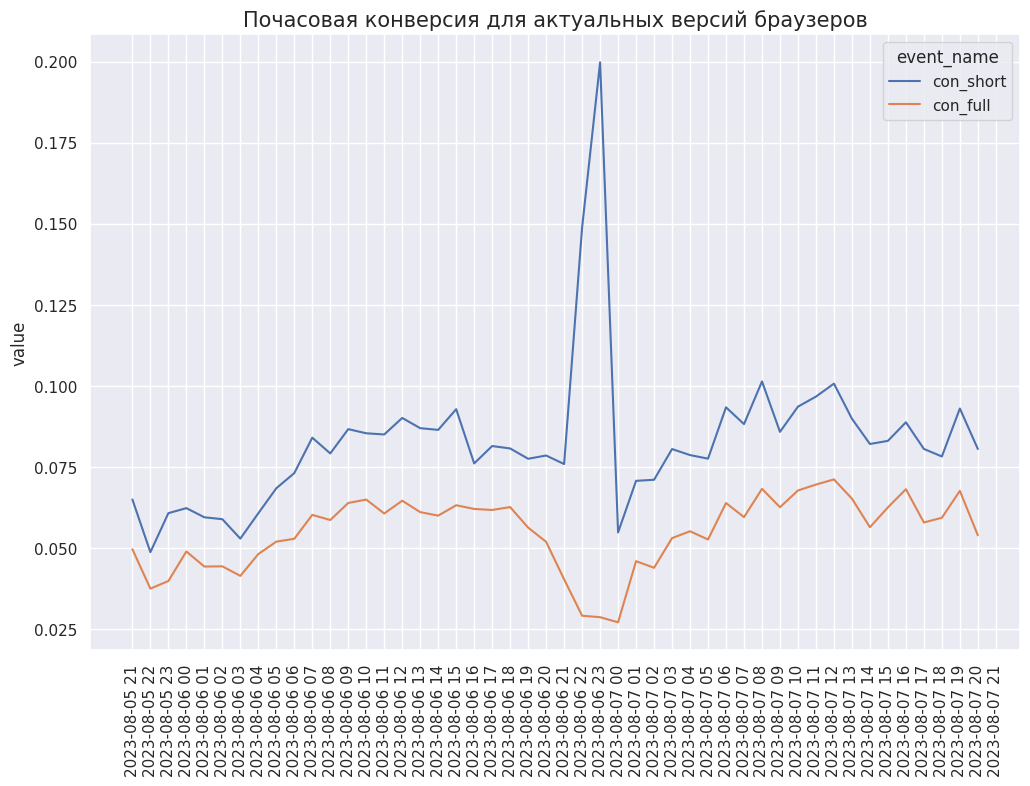

In [ ]:
con_br_actual  = br_act_gr_hour_event_name.pivot_table(values='count', index='date_hour', columns='event_name').reset_index()
con_br_actual['con_short'] = con_br_actual['short_application'] / con_br_actual['page_view']
con_br_actual['con_full'] = con_br_actual['full_application'] / con_br_actual['page_view']
con_br_actual = pd.melt(con_br_actual, id_vars=['date_hour'], value_vars=['con_short', 'con_full'])

g = sns.lineplot(data=con_br_actual, x='date_hour',
                 y='value', hue='event_name')
plt.title('Почасовая конверсия для актуальных версий браузеров', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

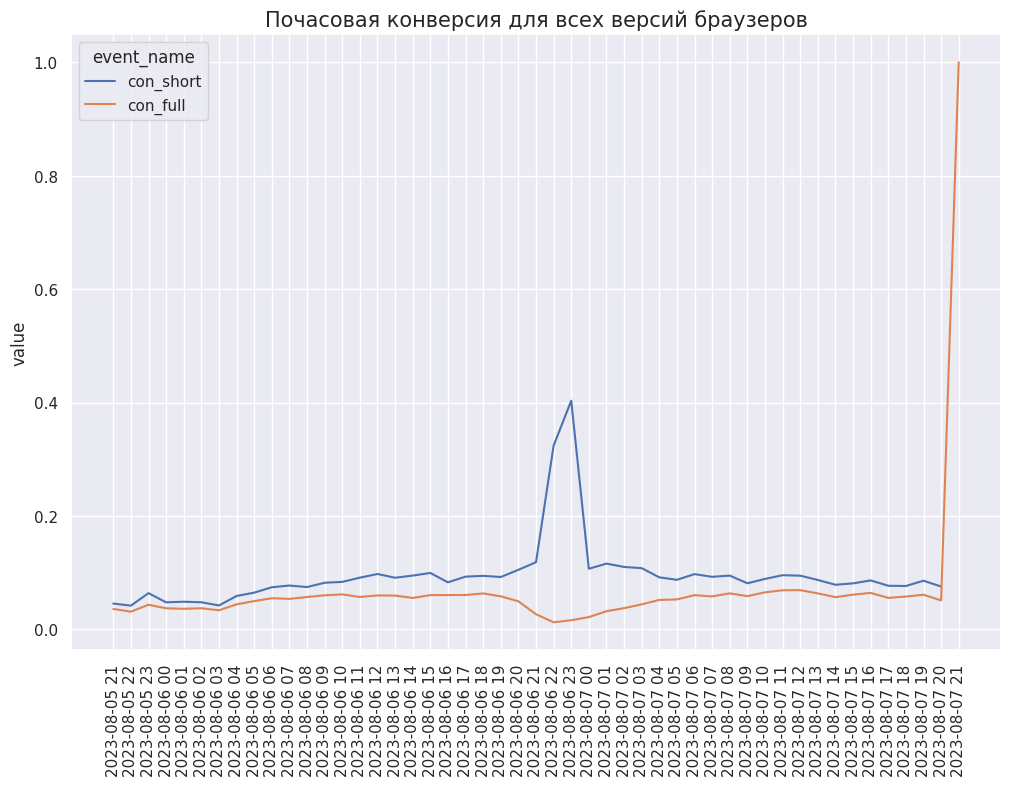

In [ ]:
con_br_all  = br_all_gr_hour_event_name.pivot_table(values='count', index='date_hour', columns='event_name').reset_index()
con_br_all['con_short'] = con_br_all['short_application'] / con_br_all['page_view']
con_br_all['con_full'] = con_br_all['full_application'] / con_br_all['page_view']
con_br_all = pd.melt(con_br_all, id_vars=['date_hour'], value_vars=['con_short', 'con_full'])

g = sns.lineplot(data=con_br_all, x='date_hour',
                 y='value', hue='event_name')
plt.title('Почасовая конверсия для всех версий браузеров', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

Если рассматривать, только актуальные версии браузеров, можно увидеть изменения в абсолютных значениях. Мы видели 6 августа с 21 до 00 7 августа большой всплеск по событиям типа page_view и short_application, который, вероятно, был вызван бот трафиком. При рассмотрении актуальных версий браузеров этого всплеска почти не наблюдается, аномалия исчезает. Если смотреть на график конверсии, то это анамалия остается, хотя показатели конверсии становятся ниже (примерно в 2 раза) для актуальных версий браузеров. Таким образом, можно использовать этот способ для отсечения бот трафика.

**Блокировщик рекламы**

In [ ]:
df[df['adblock_flg'] == 1].shape

(10261, 11)

Всего в 10 тысячах строк, есть блокировщик рекламы. Посмотрим на них.

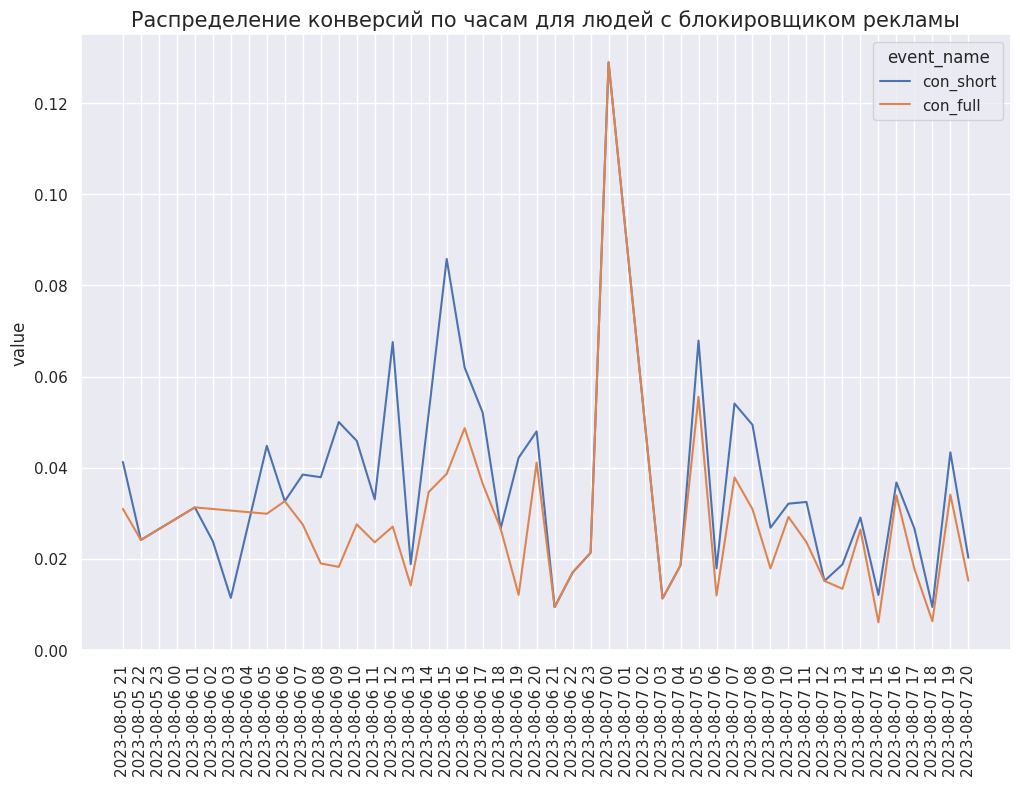

In [ ]:
df_adblock_gr_hour_event_name = df[df['adblock_flg'] == 1].groupby(['date_hour', 'event_name'], as_index=False).agg({'visitor_id': 'count'}) \
            .rename(columns={'visitor_id': 'count'})

conversions  = df_adblock_gr_hour_event_name.pivot_table(values='count', index='date_hour', columns='event_name').reset_index()
conversions['con_short'] = conversions['short_application'] / conversions['page_view']
conversions['con_full'] = conversions['full_application'] / conversions['page_view']
conversions = pd.melt(conversions, id_vars=['date_hour'], value_vars=['con_short', 'con_full'])


g = sns.lineplot(data=conversions, x='date_hour',
                 y='value', hue='event_name')
plt.title('Распределение конверсий по часам для людей с блокировщиком рекламы', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

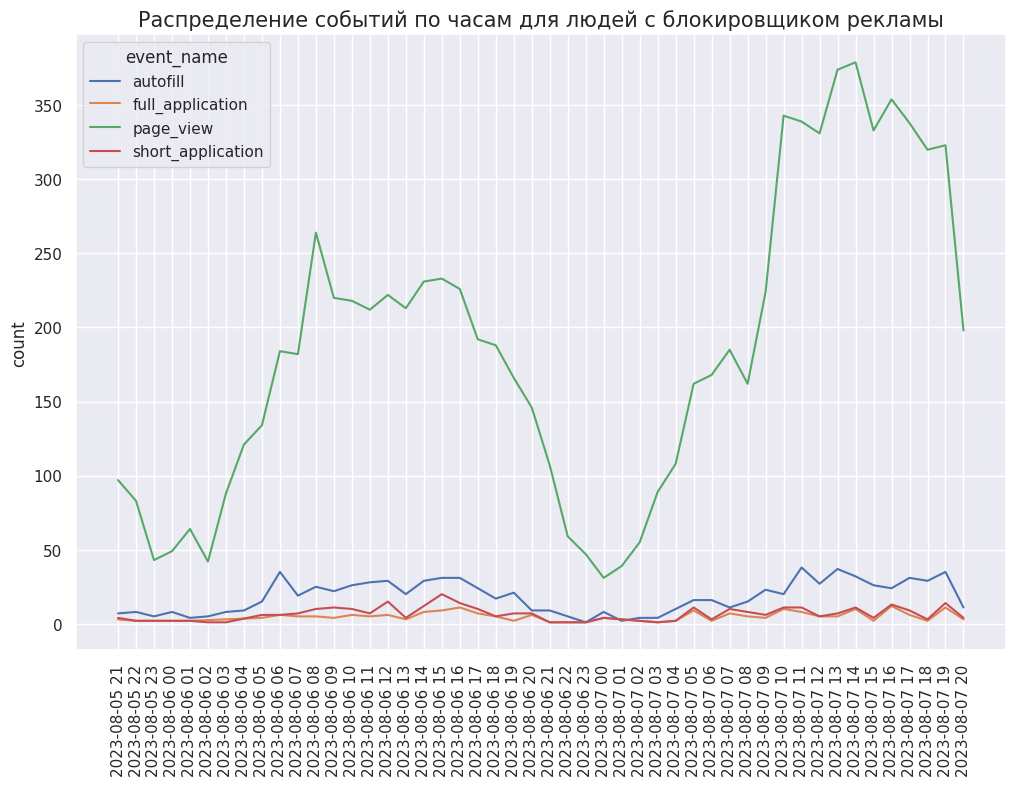

In [ ]:
g = sns.lineplot(data=df_adblock_gr_hour_event_name, x='date_hour',
                 y='count', hue='event_name')
plt.title('Распределение событий по часам для людей с блокировщиком рекламы', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

Если смотреть, на эту категорию людей, то здесь уже не видно выбросов. Предположительно и ботов здесь нет. То есть можно считать что боты не пользуются блокировщиками.

In [ ]:
visit_numbers = df.groupby('visitor_id', as_index=False).agg({'visit_number': 'max'})
visit_numbers_less_10 = visit_numbers[visit_numbers['visit_number'] <= 10]
people_less_10_visits = list(visit_numbers_less_10['visitor_id'])
df_less_10_visits = df[df['visitor_id'].isin(people_less_10_visits)]

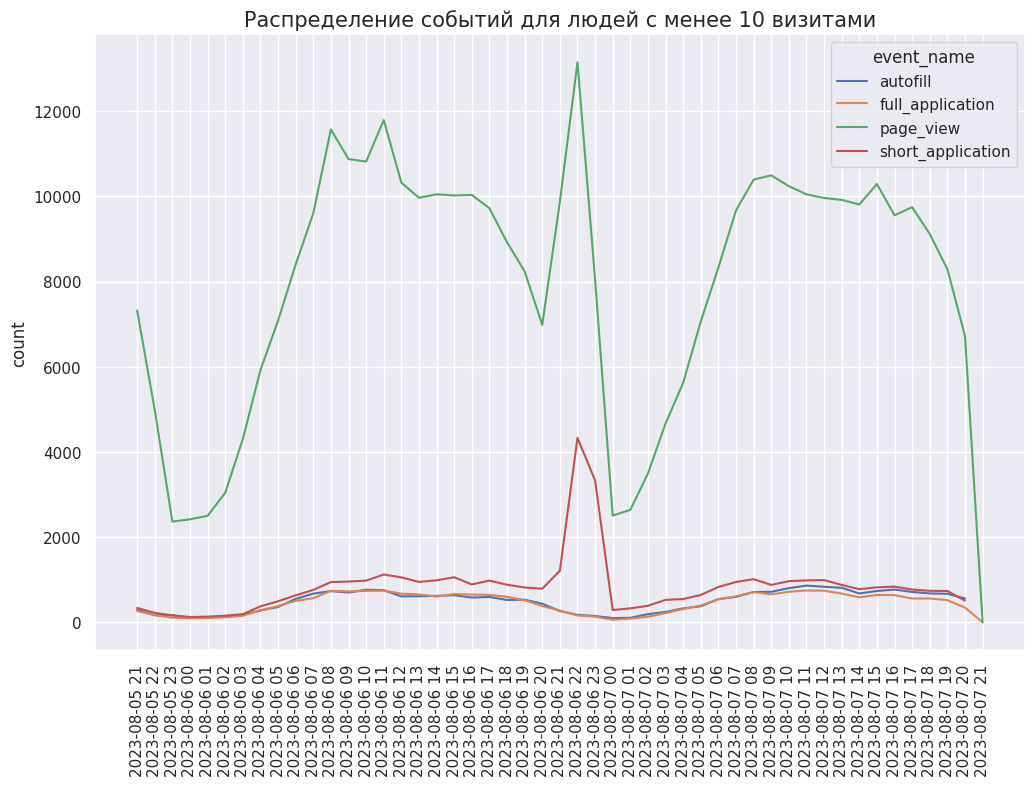

In [ ]:
df_less_10_gr_hour_event_name = df_less_10_visits.groupby(['date_hour', 'event_name'], as_index=False).agg({'visitor_id': 'count'}) \
            .rename(columns={'visitor_id': 'count'})

g = sns.lineplot(data=df_less_10_gr_hour_event_name, x='date_hour',
                 y='count', hue='event_name')
plt.title('Распределение событий для людей с менее 10 визитами', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

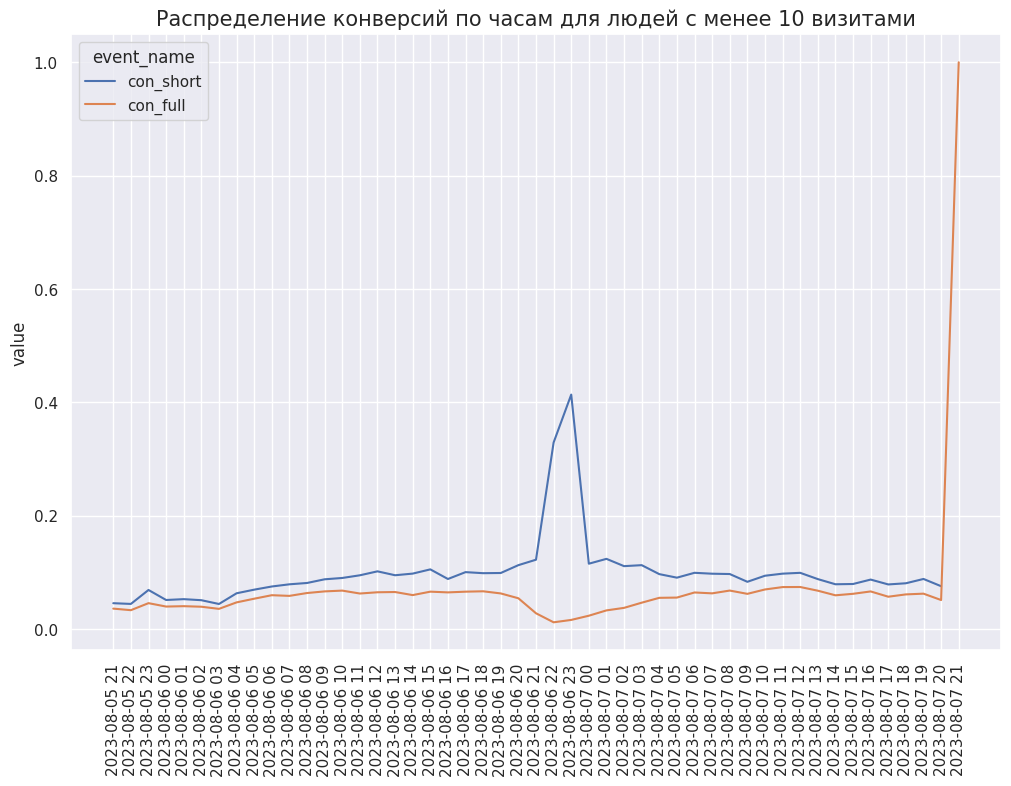

In [ ]:
conversions  = df_less_10_gr_hour_event_name.pivot_table(values='count', index='date_hour', columns='event_name').reset_index()
conversions['con_short'] = conversions['short_application'] / conversions['page_view']
conversions['con_full'] = conversions['full_application'] / conversions['page_view']
conversions = pd.melt(conversions, id_vars=['date_hour'], value_vars=['con_short', 'con_full'])


g = sns.lineplot(data=conversions, x='date_hour',
                 y='value', hue='event_name')
plt.title('Распределение конверсий по часам для людей с менее 10 визитами', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90);

Аналогично здесь есть изменения ыв числах, но поведение графиков не меняется. Можно брать разные значения визитов для отсечки (3, 5, 10, 20), ситуация остается такой же. Не получается выделить какой-то период активности ботов.

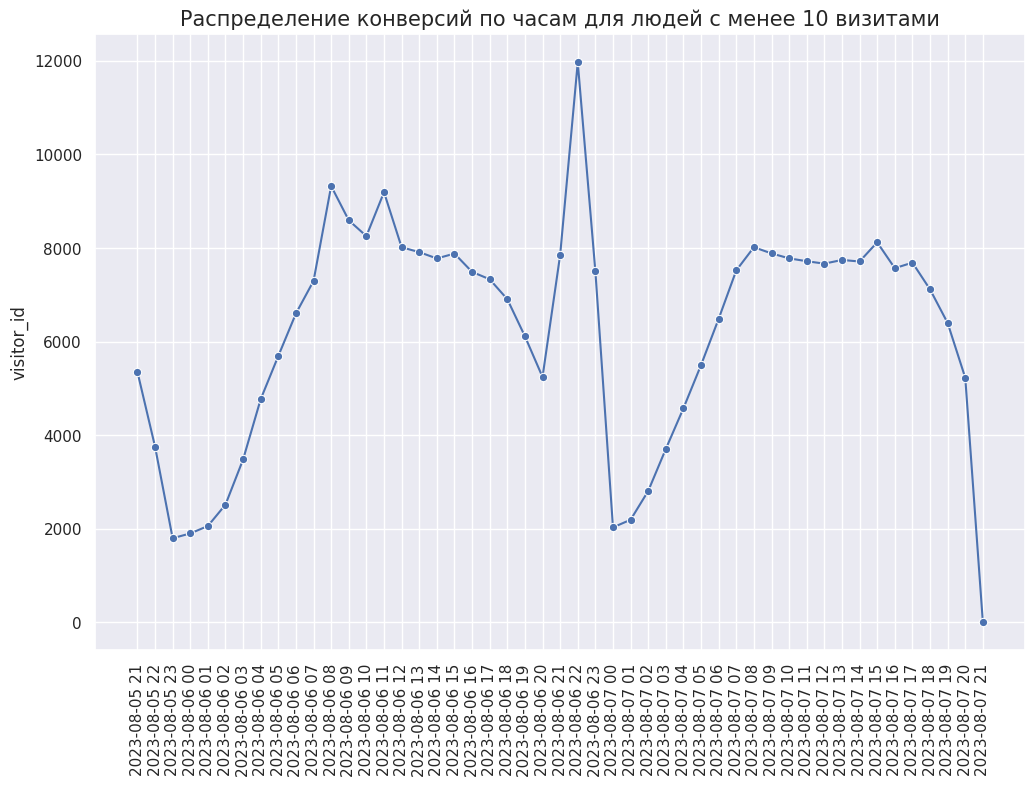

In [ ]:
df['date_hour'] = df['t'].apply(lambda x: x[:13])

unique_users_per_hour = df.groupby('date_hour')['visitor_id'].nunique().reset_index()



# Устанавливаем размер графика
sns.set(rc={'figure.figsize':(12, 8)})

# Строим линейный график
g = sns.lineplot(data=unique_users_per_hour, x='date_hour', y='visitor_id', marker = 'o', linestyle = '-')

# Задаем заголовок и метки осей
plt.title('Распределение конверсий по часам для людей с менее 10 визитами', size=15)
g.set(xlabel=None)
plt.xticks(rotation=90)

# Показываем график
plt.show()

# **Гипотеза: номер визита**

In [ ]:
visits = df[['visitor_id','visit_number']]
z_scores = zscore(visits['visit_number'])
outliers = visits[z_scores < -1]
outliers

,visitor_id,visit_number


# **Гипотеза: Время, что требуется на заполнение формы**

In [ ]:
df.t = pd.to_datetime(df.t)
df_sort = df.sort_values(['visitor_id', 't'])
df_sort['dif_time(sec)']=np.where(df_sort.visitor_id == df_sort.visitor_id.shift(), (df_sort.t - df_sort.t.shift()).dt.total_seconds(), np.nan)


Рассмотрим full_application с временем заполнения и отправки меньше duration (sec).

In [ ]:
duration = 20
id_short_filling_time = df_sort[(df_sort.event_name == 'full_application')&(df_sort['dif_time(sec)'] < duration)].visitor_id.to_list()
len(id_short_filling_time)

3244

In [ ]:
df['visitor_id'].nunique()

269677

In [ ]:
print(f'Процент потенциальных ботов на основе времени заполнения формы: {round(3244/269677,2)}%')

Процент потенциальных ботов на основе времени заполнения формы: 0.01%
